In [268]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn import tree
import os
import torch 
from decimal import Decimal
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
import math
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import matplotlib.pyplot as plt
import multiprocessing
import glob
import os
from scipy import linalg
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from torch.autograd import Variable 

In [269]:
df=pd.read_csv('data_with_ioa.csv')

In [270]:
df.drop(columns=df.columns[0], axis=1, inplace=True)

In [271]:
df

,TimeStamp,Relative Time,srcIP,dstIP,srcPort,dstPort,ipLen,len,fmt,uType,asduType,numix,cot,oa,addr,ioa,label
0,14.414498,7.988096,3232238447,3232238584,61254,2404,46,4,0,0.0,9.0,1.0,3.0,0.0,55.0,136.0,0
1,14.414498,7.988457,3232238584,3232238447,2404,61254,46,4,0,1.0,9.0,1.0,3.0,0.0,55.0,136.0,0
2,14.414519,8.191193,3232238584,3232238447,2404,61254,90,21,1,2.0,31.0,1.0,3.0,0.0,65535.0,0.0,0
3,14.414519,8.191193,3232238584,3232238447,2404,61254,90,25,1,2.0,36.0,1.0,3.0,0.0,65535.0,1.0,0
4,14.414847,11.477121,3232238584,3232238447,2404,61254,67,25,1,2.0,36.0,1.0,3.0,0.0,65535.0,1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2248192,10.443944,585025.305059,167772427,167772461,2404,49716,58,16,1,2.0,9.0,1.0,3.0,0.0,55.0,136.0,0
2248193,10.443986,585025.721693,167772427,167772461,2404,49716,58,16,1,2.0,9.0,1.0,3.0,0.0,55.0,136.0,0
2248194,10.444037,585026.232151,167772427,167772461,2404,49716,58,16,1,2.0,9.0,1.0,3.0,0.0,55.0,136.0,0
2248195,10.444088,585026.741693,167772427,167772461,2404,49716,58,16,1,2.0,9.0,1.0,3.0,0.0,55.0,136.0,0


In [272]:
#All sampling
data_train_sampled=pd.DataFrame([],columns=df.columns.values,dtype=float)
sampling=2000
for i in df['label'].unique():
    if df[df['label']==i].shape[0]>sampling:
        
        data_s = resample(df[df['label']==i], replace=False,n_samples=sampling,random_state=123)
        data_train_sampled=pd.concat([data_train_sampled,data_s])
    else:
        data_s = resample(df[df['label']==i], replace=True,n_samples=sampling,random_state=123) 
        data_train_sampled=pd.concat([data_train_sampled,data_s])

In [273]:
# X,y = df.iloc[:, :-1], df.iloc[:, [-1]]
X,y = data_train_sampled.iloc[:, :-1], data_train_sampled.iloc[:, [-1]]


In [274]:
mm = MinMaxScaler()
ss = StandardScaler()


X_ss = ss.fit_transform(X)
y_mm = mm.fit_transform(y) 


In [275]:
y_mm[:,0]

array([0., 0., 0., ..., 1., 1., 1.])

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X_ss, y_mm, test_size=0.3,random_state=109) # 70% training and 30% test


In [277]:
X_train.shape

(9800, 16)

In [278]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test)) 

In [279]:
#reshaping to rows, timestamps, features

X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

In [280]:
print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape torch.Size([9800, 1, 16]) torch.Size([9800, 1])
Testing Shape torch.Size([4200, 1, 16]) torch.Size([4200, 1])


In [281]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out


In [282]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.001 #0.001 lr

input_size = df.shape[1]-1 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = len(df['label'].unique()) #number of output classes 

In [283]:
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]) #our lstm class 

In [284]:
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate) 

In [285]:
for epoch in range(num_epochs):
  outputs = lstm1.forward(X_train_tensors_final) #forward pass
  optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
  # obtain the loss function
  loss = criterion(outputs, y_train_tensors)
 
  loss.backward() #calculates the loss of the loss function
 
  optimizer.step() #improve from loss, i.e backprop
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 

/Users/hadeerteryak/miniforge3/lib/python3.9/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([9800, 1])) that is different to the input size (torch.Size([9800, 7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 0, loss: 0.41506
Epoch: 100, loss: 0.08323
Epoch: 200, loss: 0.04887
Epoch: 300, loss: 0.04310
Epoch: 400, loss: 0.04179
Epoch: 500, loss: 0.04108
Epoch: 600, loss: 0.04046
Epoch: 700, loss: 0.03969
Epoch: 800, loss: 0.03887
Epoch: 900, loss: 0.03842


In [286]:
df_X_ss = ss.transform(df.iloc[:, :-1]) #old transformers
df_y_mm = mm.transform(df.iloc[:, -1:]) #old transformers

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))
#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1])) 

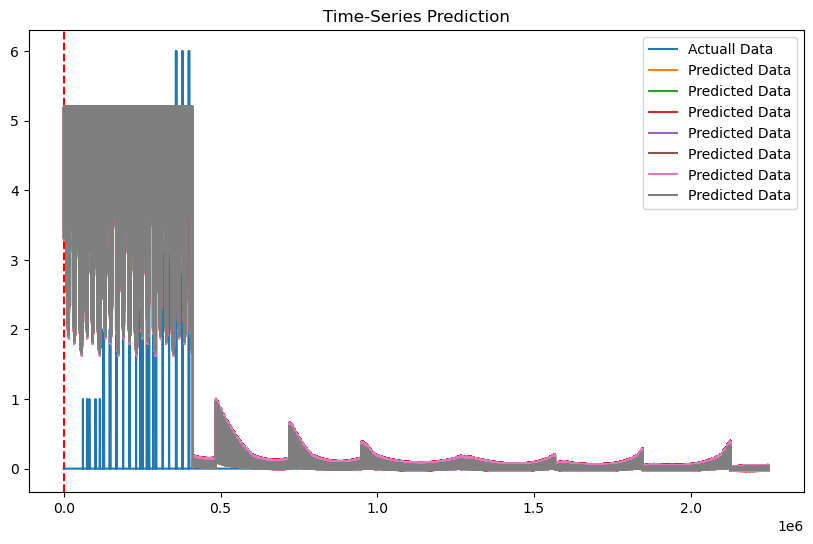

In [287]:
train_predict = lstm1(df_X_ss)#forward pass
data_predict = train_predict.data.numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
plt.figure(figsize=(10,6)) #plotting
plt.axvline(x=200, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

In [259]:
dataY_plot


array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

In [260]:
np.argmax(data_predict,axis=1)

array([4, 1, 4, ..., 1, 1, 1])

In [261]:
print(metrics.classification_report(dataY_plot, np.argmax(data_predict,axis=1)))

/Users/hadeerteryak/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hadeerteryak/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hadeerteryak/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hadeerte

              precision    recall  f1-score   support

         0.0       0.81      0.06      0.12   1644290
         1.0       0.00      0.00      0.00         0
         2.0       0.00      0.00      0.00         0
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0
         5.0       0.00      0.00      0.00         0
         7.0       0.00      0.00      0.00     43403
         8.0       0.00      0.00      0.00     43831
         9.0       0.00      0.00      0.00     16542
        10.0       0.00      0.00      0.00     27504
        11.0       0.00      0.00      0.00     37363

    accuracy                           0.06   1812933
   macro avg       0.07      0.01      0.01   1812933
weighted avg       0.74      0.06      0.11   1812933



/Users/hadeerteryak/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/hadeerteryak/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
